In [1]:
# Input info
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/gff_A2_black/annotation_clones/fate_correlation/minC5_corr.Kendall.b/"
se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
use_input = False
min_cell = 5
input_col = "Input"
corr_method = "kendall_b"

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import colorcet as cc
%matplotlib inline
import numpy as np
from mplh.fig_utils import helper_save as hs

import networkx as nx

fig_utils from mplh


In [3]:
sns.set(font_scale = 1.3)


In [4]:
def keep_top_clones(df, n_top=None, min_cell=0):
    df = df.sort_values("ncells",ascending=False)
    if n_top is not None:
        df = df[:n_top]
    return df.loc[df["ncells"]>min_cell]

In [5]:
def get_clone_count(x, clone_counts):
    curr = clone_counts[clone_counts["name"]==x.name]
    return curr.set_index("nuclear_clusters")["ncells"]


In [6]:
se_cells_meta = pd.read_csv(se_cells_meta_f, sep='\t')
if "cluster_labels" in se_cells_meta.columns:
    se_cells_meta = se_cells_meta.rename({"cluster_labels":"nuclear_clusters"}, axis=1)
else:
    se_cells_meta = se_cells_meta.rename({"seurat_clusters":"nuclear_clusters"}, axis=1)

palette = sns.color_palette(cc.glasbey, n_colors=len(se_cells_meta["nuclear_clusters"].unique()))
hue_order = se_cells_meta.groupby("nuclear_clusters").size().sort_values()[::-1].index
color_d = {key:val for key, val in zip(hue_order, palette)}

### Remove None before normalizing
if use_input:
    se_cells_meta = se_cells_meta[se_cells_meta["orig.ident"] == input_col]
se_cells_meta = se_cells_meta[se_cells_meta["donor"] != "None"]
se_cells_meta

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,seurat_clusters,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,nuclear_clusters
Flt3l_AAACGAAGTCTGATTG-1,Flt3l,4239,4239,15047,1940,50,52,636,4173,8196,...,6,5280,4119,AAACGAAGTCTGATTG-1_Flt3l,Flt3l_AAACGAAGTCTGATTG-1,2,0,Flt3l,0_2,HSPC 3
Flt3l_AAACTCGGTAGGTCTT-1,Flt3l,2925,2925,13052,1674,43,26,526,4014,6769,...,3,4538,3532,AAACTCGGTAGGTCTT-1_Flt3l,Flt3l_AAACTCGGTAGGTCTT-1,16,1,Flt3l,1_16,B-cell lineage
Flt3l_AAAGGGCAGACTTCCA-1,Flt3l,3562,3562,14297,2199,46,34,695,3497,7826,...,4,4653,3642,AAAGGGCAGACTTCCA-1_Flt3l,Flt3l_AAAGGGCAGACTTCCA-1,13,0,Flt3l,0_13,Classical Monocyte
Flt3l_AAATGAGGTATCCTTT-1,Flt3l,4915,4915,16671,2497,75,62,760,2906,10371,...,9,6459,4673,AAATGAGGTATCCTTT-1_Flt3l,Flt3l_AAATGAGGTATCCTTT-1,18,0,Flt3l,0_18,Non-classical monocyte
Flt3l_AAATGCCGTGATAAGT-1,Flt3l,3886,3886,15323,2276,44,49,723,3740,8491,...,4,5109,3980,AAATGCCGTGATAAGT-1_Flt3l,Flt3l_AAATGCCGTGATAAGT-1,6,0,Flt3l,0_6,Classical Monocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Input_TTTGTGTGTTTCTTAC-1,Input,3580,3580,17067,3257,63,80,461,8097,5109,...,0,3738,2899,TTTGTGTGTTTCTTAC-1_Input,Input_TTTGTGTGTTTCTTAC-1,1,0,Input,0_1,HPSC 1
Input_TTTGTGTTCCTGAAAC-1,Input,4328,4328,30427,8323,84,99,799,12146,8976,...,7,5839,4144,TTTGTGTTCCTGAAAC-1_Input,Input_TTTGTGTTCCTGAAAC-1,27,0,Input,0_27,Erythroid lineage
Input_TTTGTGTTCGGGAAAC-1,Input,8010,8010,40114,14032,169,160,1561,10102,14090,...,0,9421,5890,TTTGTGTTCGGGAAAC-1_Input,Input_TTTGTGTTCGGGAAAC-1,19,0,Input,0_19,HPSC 1
Input_TTTGTGTTCGGGACAA-1,Input,3286,3286,22721,4421,43,84,546,11692,5935,...,3,4303,3323,TTTGTGTTCGGGACAA-1_Input,Input_TTTGTGTTCGGGACAA-1,2,1,Input,1_2,B-cell lineage


In [7]:
clone_counts = se_cells_meta.groupby(["name", "nuclear_clusters","donor"]).size().reset_index().rename({0:"ncells"}, axis=1)
clone_counts = clone_counts[~(clone_counts["name"]=="None")]
clone_counts_combined = clone_counts.groupby(["name", "donor"]).sum()["ncells"].reset_index().sort_values("ncells", ascending=False).set_index("name")

clone_counts_df = pd.concat((clone_counts_combined, clone_counts_combined.apply(get_clone_count, axis=1, args=(clone_counts,))),axis=1).fillna(0)

log2_clone_counts_df = clone_counts_df.copy()
log2_clone_counts_df[hue_order] = np.log2(1+log2_clone_counts_df[hue_order])
log2_clone_counts_df



,donor,ncells,B-cell lineage,Basophil;Eosinophil,Classical Monocyte,Erythroid lineage,HPSC 1,HPSC 2,HSPC 3,HSPC 4,Neutrophil,Non-classical monocyte,pDC,pre-B cells
name,,,,,,,,,,,,,,
0_0,0,429,3.700440,3.906891,3.906891,4.754888,7.357552,6.768184,4.169925,1.584963,4.247928,1.000000,4.807355,4.807355
1_0,1,317,3.906891,3.584963,0.000000,5.426265,6.209453,6.781360,5.209453,2.000000,3.321928,1.000000,3.807355,2.807355
0_1,0,268,2.584963,3.000000,3.000000,4.700440,6.727920,6.169925,3.321928,0.000000,2.807355,1.584963,3.459432,4.459432
0_2,0,230,3.321928,3.321928,2.000000,4.459432,6.507795,5.906891,3.000000,1.000000,2.807355,3.169925,3.584963,2.807355
1_1,1,196,2.000000,2.000000,2.584963,4.807355,5.977280,5.906891,4.523562,0.000000,3.321928,0.000000,2.584963,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0_34,0,23,1.000000,0.000000,0.000000,1.000000,3.169925,3.169925,1.000000,0.000000,0.000000,1.584963,1.000000,1.000000
1_23,1,22,0.000000,0.000000,0.000000,2.000000,2.584963,3.321928,2.584963,0.000000,0.000000,0.000000,0.000000,0.000000
0_35,0,21,1.000000,1.000000,0.000000,2.000000,2.807355,3.169925,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000


## Fate correlation

In [8]:
## Get top, middle, and bottom 2 correlations - Conditions combined

def repr_vals(x, n=2):
    """Get top, middle, and bottom 2 correlations - Conditions combined
    
    Assumes values are sorted
    """
    x_len = len(x)
    top = x[:min(len(x),n)]
    bot = []
    if x_len >= n*2:
        bot = x[::-1][:n]
        mid = []
        if x_len >= n*3:
            mid = x[int((len(x)/2)-(n/2)): int((len(x)/2)+(n/2))]
    return np.concatenate((top, bot, mid))


def top_vals(x, n=5):
    """Assumes values are sorted"""
    x_len = len(x)
    return x[:min(len(x),n)]


def repr_df(corr_vals, all_corr_df):
    repr_corr = all_corr_df.isin(corr_vals)
    repr_corr_inds = repr_corr[repr_corr > 0].stack().index.tolist()
    repr_corr_inds_df = pd.DataFrame(repr_corr_inds)
    repr_corr_inds_df["nm"] = repr_corr_inds_df.apply(lambda x: "-MERGE-".join(np.sort(x.values)), axis=1)

    repr_corr_inds_df = repr_corr_inds_df.loc[~(repr_corr_inds_df.duplicated(subset=["nm"]))].drop("nm", axis=1)
    repr_corr_inds_df["spearman corr"] = repr_corr_inds_df.apply(lambda x: all_corr_df.loc[x[0], x[1]], axis=1)
    repr_corr_inds_df = repr_corr_inds_df.sort_values("spearman corr")[::-1]
    return repr_corr_inds_df

def corr_df_flatten(df):
    vals = np.sort(list(set(df.values.flatten())))[::-1]
    return vals[vals!=1] # remove the diagonals

def plot_repr_corr(df, all_corr_df, label, top=False, out_f=None):
    vals = corr_df_flatten(all_corr_df)
    if top:
        corr_vals = top_vals(vals, n=5) #top, middle, and bottom n correlations
    else:
        corr_vals = repr_vals(vals, n=2) #top, middle, and bottom n correlations
    repr_corr_inds_df = repr_df(corr_vals, all_corr_df)
    corr_cat_df = []
    for ind, val in repr_corr_inds_df.iterrows():
        curr = df.loc[:,[val[0], val[1]]].copy()
        curr["comp"] = f'{"__".join(curr.columns)} ({corr_method} r={val["spearman corr"]:.3f})'
        curr = curr.rename({val:str(ind) for ind, val in enumerate([val[0], val[1]])}, axis=1)
        corr_cat_df.append(curr)
        
    g = sns.lmplot(data=pd.concat(corr_cat_df,axis=0), x="0", y="1", hue="comp", height=12);
    plt.ylabel(label)
    plt.xlabel(label)
    plt.suptitle("Top, middle, and bottom 2 paired correlations")
    if top:
        plt.suptitle(f"Top 5 paired correlations")
    if out_f is not None:
        hs(out_f, to_pdf=True)
    return corr_cat_df

In [9]:
from scipy.stats import kendalltau
def kendalltau_b(x,y):
    #print('kendall', kendalltau(x, y, variant='b'))
    return kendalltau(x, y, variant='b')[0]

def get_corr(df, corr_method):
    df = df.copy().drop(["ncells", "donor"],axis=1, errors='ignore')
    if corr_method == "spearman":
        return df.corr(method="spearman")
    elif corr_method == "kendall_b":
        return df.corr(method=kendalltau_b)



### a) Donors in sequenced run combined (min_cell)

Text(0.5, 0.98, 'allDonors (clone size > 5)')

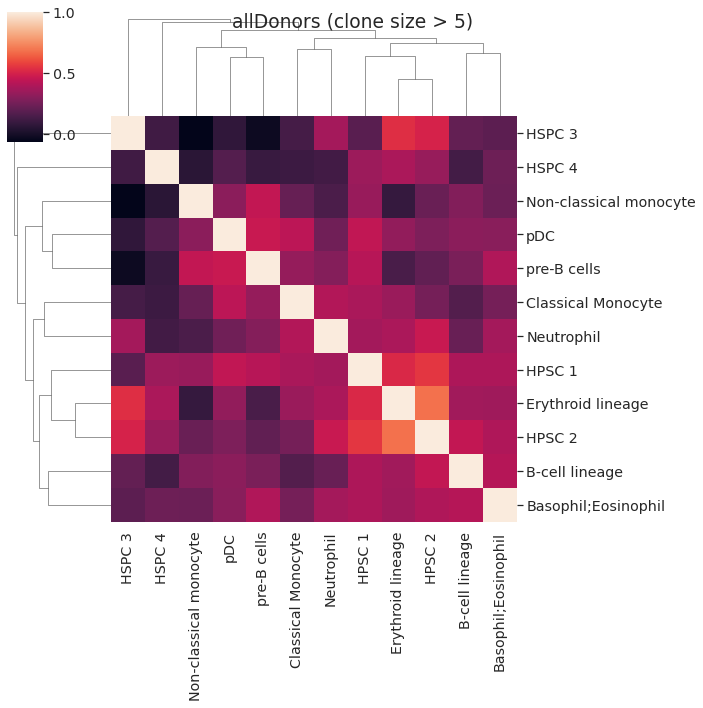

In [10]:
filt_clone_counts_df = keep_top_clones(clone_counts_df, min_cell=min_cell)

all_corr_df = get_corr(filt_clone_counts_df, corr_method)
# if corr_method == "spearman":
#     all_corr_df = np.log2(1+filt_clone_counts_df.drop(["ncells", "donor"],axis=1)).corr(method="spearman")
# elif corr_method == "kendall_b":
#     all_corr_df = np.log2(1+filt_clone_counts_df.drop(["ncells", "donor"],axis=1)).corr(method=kendalltau_b)


all_corr_df
sns.clustermap(all_corr_df)
plt.suptitle(f"allDonors (clone size > {min_cell})")


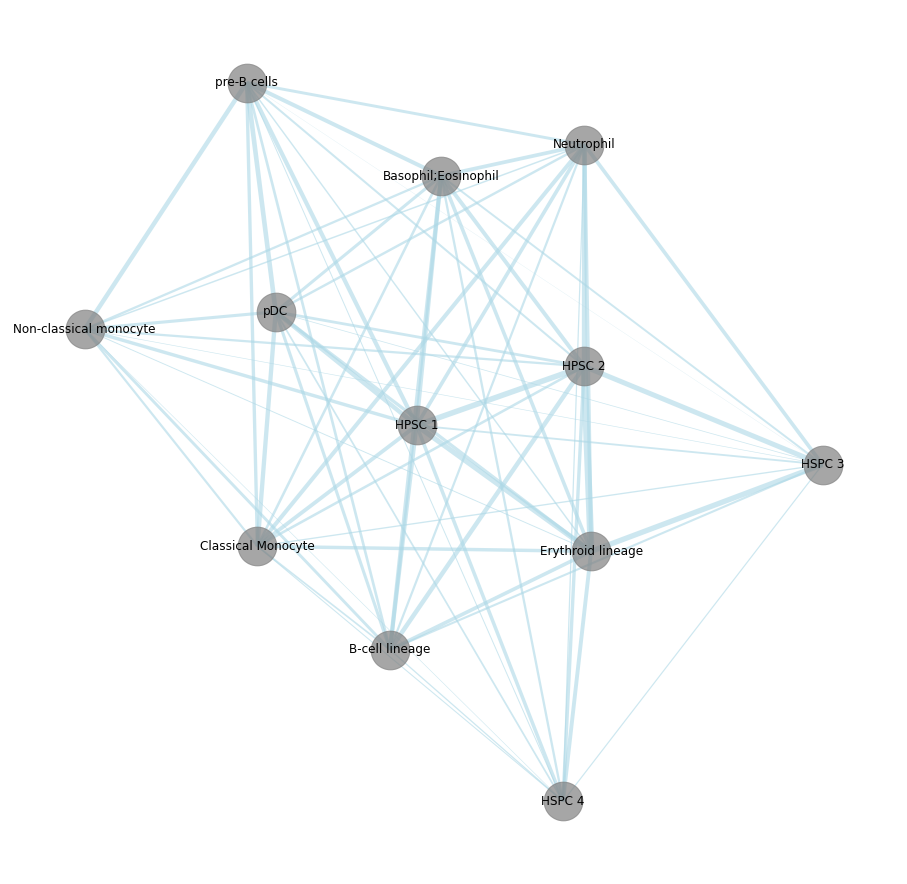

In [11]:
edges = all_corr_df.reset_index().melt(id_vars=["index"]).rename({"index":"edgeA", "variable":"edgeB"}, axis=1)

G = nx.Graph()
for ind, val in edges.iterrows():
    if val["edgeA"] != val["edgeB"]:
        G.add_edge(val["edgeA"], val["edgeB"], weight=val["value"]*10)

widths = nx.get_edge_attributes(G, 'weight')
nodelist = G.nodes()

plt.figure(figsize=(16,16))

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=1500,
                       node_color='grey',
                       alpha=0.7)
nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                       edge_color='lightblue',
                       alpha=0.6)
nx.draw_networkx_labels(G, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                        font_color='black')
plt.box(False)
hs(join(outdir, "fate_corr_network.png"), to_pdf=True)
plt.show()

### b) Separate donors, min_cell=min_cell

In [12]:
# for don, val in clone_counts_df.groupby("donor"):
#     tmp = keep_top_clones(val, min_cell=min_cell)
#     #corr_df = np.log2(1+tmp.drop(["ncells", "donor"],axis=1)).corr(method="spearman")
#     corr_df = get_corr(tmp, corr_method)
#     corr_df

#     sns.clustermap(corr_df)
#     plt.suptitle(f"Donor {don} (clone size > {min_cell})")
#     hs(join(outdir, f"fateCorr_donor{don}.png"), to_pdf=True)


# ### c) Separate donors, min_cell is 50

# for don, val in clone_counts_df.groupby("donor"):
#     tmp = keep_top_clones(val, min_cell=50)
#     #corr_df = np.log2(1+tmp.drop(["ncells", "donor"],axis=1)).corr(method="spearman")
#     corr_df = get_corr(tmp, corr_method)
#     corr_df

#     sns.clustermap(corr_df)
#     plt.suptitle(f"Donor {don} (clone size > 50)")

## Separate donors, no min_cell

# for don, val in clone_counts_df.groupby("donor"):
#     tmp = keep_top_clones(val, min_cell=0)
#     #corr_df = np.log2(1+val.drop(["ncells", "donor"],axis=1)).corr(method="spearman")
#     corr_df = get_corr(val, corr_method)
#     sns.clustermap(corr_df)
#     plt.suptitle(f"Donor {don} (all clones)")

### d) Normalize per donor, run donors together and separately

In [13]:
filt_clone_counts = keep_top_clones(clone_counts, min_cell=min_cell)
clone_norm = filt_clone_counts.copy()

#clone_sums = clone_counts.groupby("name").sum()["ncells"]

clone_norm["ncells"] = np.log2(1+clone_norm["ncells"])
clone_sums = filt_clone_counts.groupby(["donor"]).sum()["ncells"]

clone_norm["ncells"] = clone_norm.apply(lambda x: x["ncells"]/clone_sums.loc[(x["donor"])] , axis=1)
clone_norm = clone_norm[~(clone_norm["name"]=="None")]
clone_norm_combined = clone_norm.groupby(["name", "donor", "nuclear_clusters"]).sum()["ncells"].reset_index().sort_values("ncells", ascending=False).set_index("name")
clone_norm_combined


,donor,nuclear_clusters,ncells
name,,,
1_0,1,HPSC 2,0.002957
1_0,1,HPSC 1,0.002708
1_5,1,HPSC 2,0.002691
1_4,1,HPSC 2,0.002664
1_1,1,HPSC 1,0.002607
...,...,...,...
0_8,0,Neutrophil,0.000898
0_8,0,pDC,0.000898
0_21,0,Neutrophil,0.000898


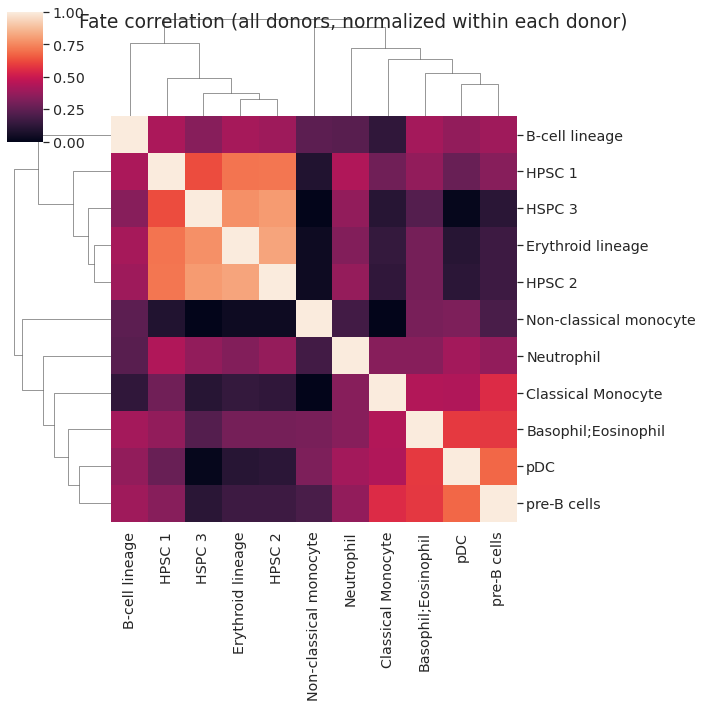

In [14]:

clone_norm_df = pd.concat((clone_norm_combined, clone_norm_combined.apply(get_clone_count, axis=1, args=(clone_norm,))),axis=1).fillna(0)
#norm_corr_df = clone_norm_df.drop(["ncells", "donor"],axis=1).corr(method="spearman")

norm_corr_df = get_corr(clone_norm_df, corr_method)

sns.clustermap(norm_corr_df.loc[(~norm_corr_df.isnull().all(axis=1)),(~norm_corr_df.isnull().all())], vmin=0, vmax=1)
plt.suptitle("Fate correlation (all donors, normalized within each donor)")
hs(join(outdir, "norm_allDonors.png"), to_pdf=True)

# for don, val in clone_norm_df.groupby("donor"):
#     #corr_df = val.drop(["ncells", "donor"],axis=1).corr(method="spearman")
#     corr_df = get_corr(val, corr_method)
#     sns.clustermap(corr_df.loc[(~corr_df.isnull().all(axis=1)),(~corr_df.isnull().all())].fillna(0), vmin=0, vmax=1)
#     plt.suptitle(f"Donor {don} (Normalized clone sizes)")

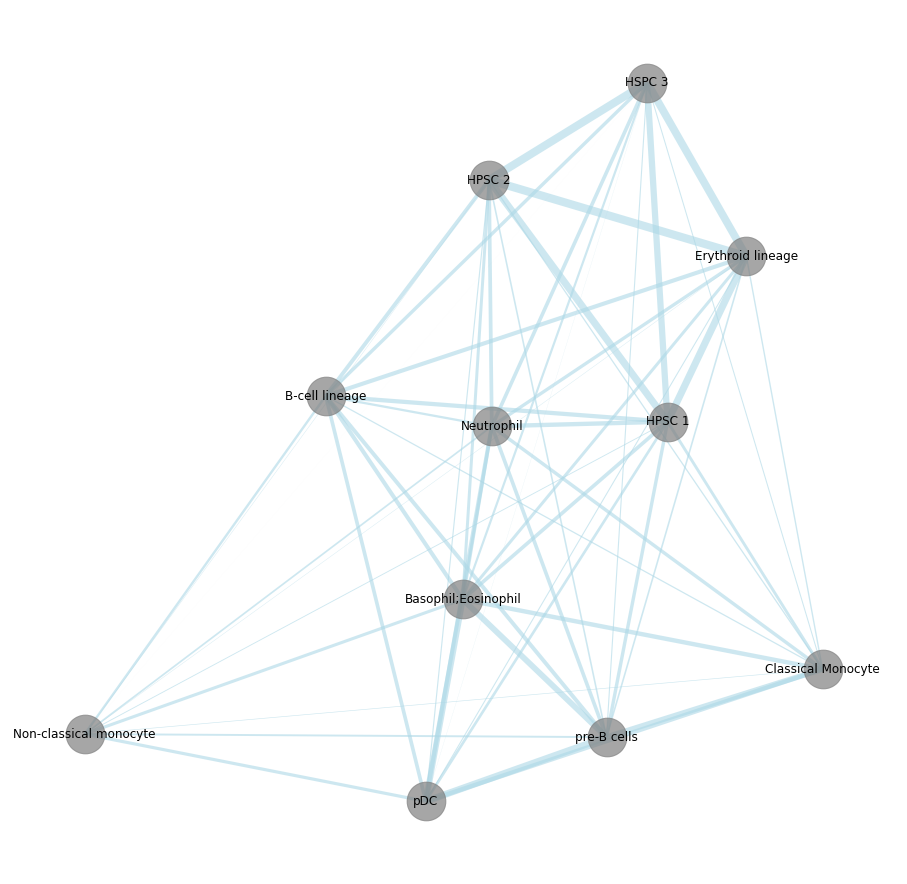

<Figure size 432x288 with 0 Axes>

In [15]:
edges = norm_corr_df.reset_index().melt(id_vars=["index"]).rename({"index":"edgeA", "variable":"edgeB"}, axis=1)
edges["norm_value"] = edges["value"]/edges["value"].mean()
edges

G = nx.Graph()
for ind, val in edges.iterrows():
    if val["edgeA"] != val["edgeB"]:
        G.add_edge(val["edgeA"], val["edgeB"], weight=val["value"]*10)

widths = nx.get_edge_attributes(G, 'weight')
nodelist = G.nodes()

plt.figure(figsize=(16,16))

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=1500,
                       node_color='grey',
                       alpha=0.7)
nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                       edge_color='lightblue',
                       alpha=0.6)
nx.draw_networkx_labels(G, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                        font_color='black')
plt.box(False)
plt.show()
hs(join(outdir, "norm_fate_corr_network.png"), to_pdf=True)

---

---

In [16]:
outdir

'/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/gff_A2_black/annotation_clones/fate_correlation/minC5_corr.Kendall.b/'